In [2]:
import numpy as np
import torch
import torch.nn as nn
from basic_model import DeepModel_single, gradients
from visual_data import matplotlib_vision

import time
from tqdm import trange
import matplotlib.pyplot as plt

#### 1d-非定态Schrodinger方程
求复数解 $h(t,x) = u(t,x)+iv(t,x)$
$$
    ih_t + 0.5h_xx+h^2 h=0,
    h(0, x)=2sech(x)\\
    h(t, -5)=h(t, 5)\\
    h_x(t, -5)=h_x(t, 5)
$$

In [3]:
import os
name = 'Schrodinger-1d-t'
work_path = os.path.join('work', name)
isCreated = os.path.exists(work_path)
if not isCreated:
    os.makedirs(work_path)

class Net(DeepModel_single):
    def __init__(self, planes):
        super(Net, self).__init__(planes, active=nn.GELU())

    def equation(self, inn_var, out_var):
        duda = gradients(out_var[..., (0,)], inn_var)
        dvda = gradients(out_var[..., (1,)], inn_var)
        dudt, dvdt = duda[..., (0,)], dvda[..., (0,)]
        dudx, dvdx = duda[..., (1,)], dvda[..., (1,)]
        d2udx2 = gradients(dudx, inn_var)[..., (1,)]
        d2vdx2 = gradients(dvdx, inn_var)[..., (1,)]
        f_u = dudt + 0.5*d2vdx2 + (out_var[..., (0,)]**2 + out_var[..., (1,)]**2)*out_var[..., (1,)]
        f_v = dvdt - 0.5*d2udx2 - (out_var[..., (0,)]**2 + out_var[..., (1,)]**2)*out_var[..., (0,)]
        res = torch.cat((f_u, f_v), dim=-1)
        return res, torch.cat((dudx, dvdx), dim=-1)


#### 数据生成，读入数值解

Text(0, 0.5, '$x$')

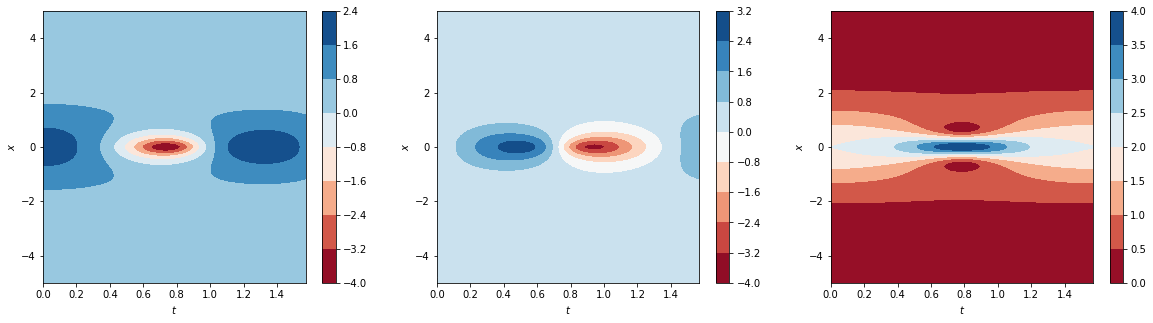

In [5]:

import scipy.io as sio
data = sio.loadmat('data\\schrodinger\\NLS.mat')

times = data['tt'].flatten()[:, None].astype(np.float32)  # Nt x 1
nodes = data['x'].flatten()[:, None].astype(np.float32)  # Nx x 1
field = data['uu'][:, :, None]  # N x T
field = np.concatenate((np.real(field), np.imag(field)), axis=-1).astype(np.float32).transpose((1, 0, 2))

node_t = np.tile(times, (1, nodes.shape[0]))  # Nt x Nx
node_x = np.tile(nodes, (1, times.shape[0])).T # Nt x Nx

node_x = np.concatenate((node_x, node_x[:, (0,)]), axis=1); node_x[:, -1] = 5.
node_t = np.concatenate((node_t, node_t[:, (0,)]), axis=1)
input = np.stack((node_t, node_x), axis=-1)
field = np.concatenate((field, field[:, (0,), :]), axis=1)
Nt, Nx, = times.shape[0], times.shape[1]

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

input_train = torch.tensor(input, dtype=torch.float32).to(device)
field_train = torch.tensor(field, dtype=torch.float32).to(device)

plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.contourf(node_t, node_x, field[..., 0], cmap='RdBu')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.subplot(132)
plt.contourf(node_t, node_x, field[..., 1], cmap='RdBu')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.subplot(133)
plt.contourf(node_t, node_x, np.sqrt(field[..., 0]**2 + field[..., 1]**2), cmap='RdBu')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

#### 定义训练过程

In [14]:
# 建立网络
Net_model = Net(planes=[2, 32, 32, 32, 32, 2],).to(device)
# 损失函数
L2loss = nn.MSELoss()
# 优化算法
Optimizer = torch.optim.Adam(Net_model.parameters(), lr=0.001, betas=(0.7, 0.9))
# 下降策略
Scheduler = torch.optim.lr_scheduler.MultiStepLR(Optimizer, milestones=[20000, 30000, 40000], gamma=0.1)
# 可视化
Visual = matplotlib_vision('/', input_name=('t', 'x'), field_name=('Re', 'Im'))

def train(inn_var, bounds, out_true, model, Loss, optimizer, scheduler, log_loss):

    def closure():

        optimizer.zero_grad()
        out_var = model(inn_var)
        res_i, dhdx = model.equation(inn_var, out_var)
        ics_loss = Loss(out_var[0, :], out_true[0, :])
        bcs_loss_1 = Loss(out_var[:, 0], out_true[:, -1])
        bcs_loss_2 = Loss(dhdx[:, 0], dhdx[:, -1])
        eqs_loss = Loss(res_i, torch.zeros_like(res_i, dtype=torch.float32))
        bcs_loss = bcs_loss_1 + bcs_loss_2
        loss_batch = bcs_loss + eqs_loss + ics_loss
        loss_batch.backward()

        data_loss = Loss(out_var, out_true)
        log_loss.append([eqs_loss.item(), bcs_loss.item(), ics_loss.item(), data_loss.item()])

        return loss_batch

    optimizer.step(closure)
    scheduler.step()

def inference(inn_var, model):

    out_pred = model(inn_var)
    equation, _ = model.equation(inn_var, out_pred)

    return out_pred, equation

#### 执行训练过程

In [15]:
star_time = time.time()
log_loss = []
pbar = trange(100000)

inn_var = input_train
inn_var.requires_grad_(True)

# Training
for iter in pbar:

    learning_rate = Optimizer.state_dict()['param_groups'][0]['lr']
    train(inn_var, [], field_train, Net_model, L2loss, Optimizer, Scheduler, log_loss)

    # if iter > 0 and iter % 200 == 0:
    # print('iter: {:6d}, lr: {:.3e}, eqs_loss: {:.3e}, dat_loss: {:.3e}, bon_loss1: {:.3e}, cost: {:.2f}'.
    #       format(iter, learning_rate, log_loss[-1][0], log_loss[-1][-1], log_loss[-1][1], time.time()-star_time))

    pbar.set_postfix({'lr': learning_rate, 'dat_loss': log_loss[-1][-1], 'cost:':  time.time()-star_time,
                      'eqs_loss': log_loss[-1][0], 'bcs_loss': log_loss[-1][1], 'ics_loss': log_loss[-1][2], })

torch.save({'log_loss': log_loss, 'model': Net_model.state_dict(), }, os.path.join(work_path, 'latest_model.pth'))

100%|██████████| 100000/100000 [54:17<00:00, 30.70it/s, lr=1e-6, dat_loss=0.00073, cost:=3.26e+3, eqs_loss=3.33e-5, bcs_loss=6.88e-7, ics_loss=3.79e-6]


#### 训练过程损失可视化

Text(0.5, 1.0, 'training loss')

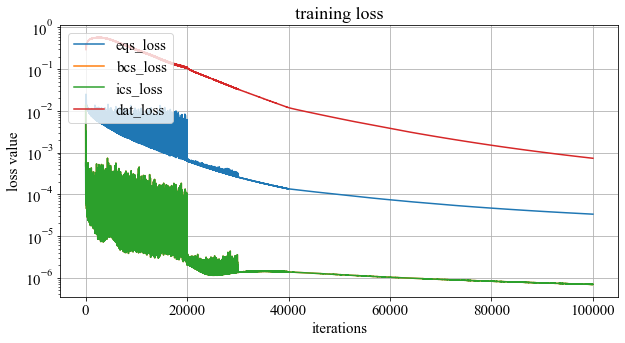

In [16]:
plt.figure(2, figsize=(10, 5))
plt.clf()
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 0], 'eqs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'bcs_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, 1], 'ics_loss')
Visual.plot_loss(np.arange(len(log_loss)), np.array(log_loss)[:, -1], 'dat_loss')
plt.title('training loss')

#### 结果展示

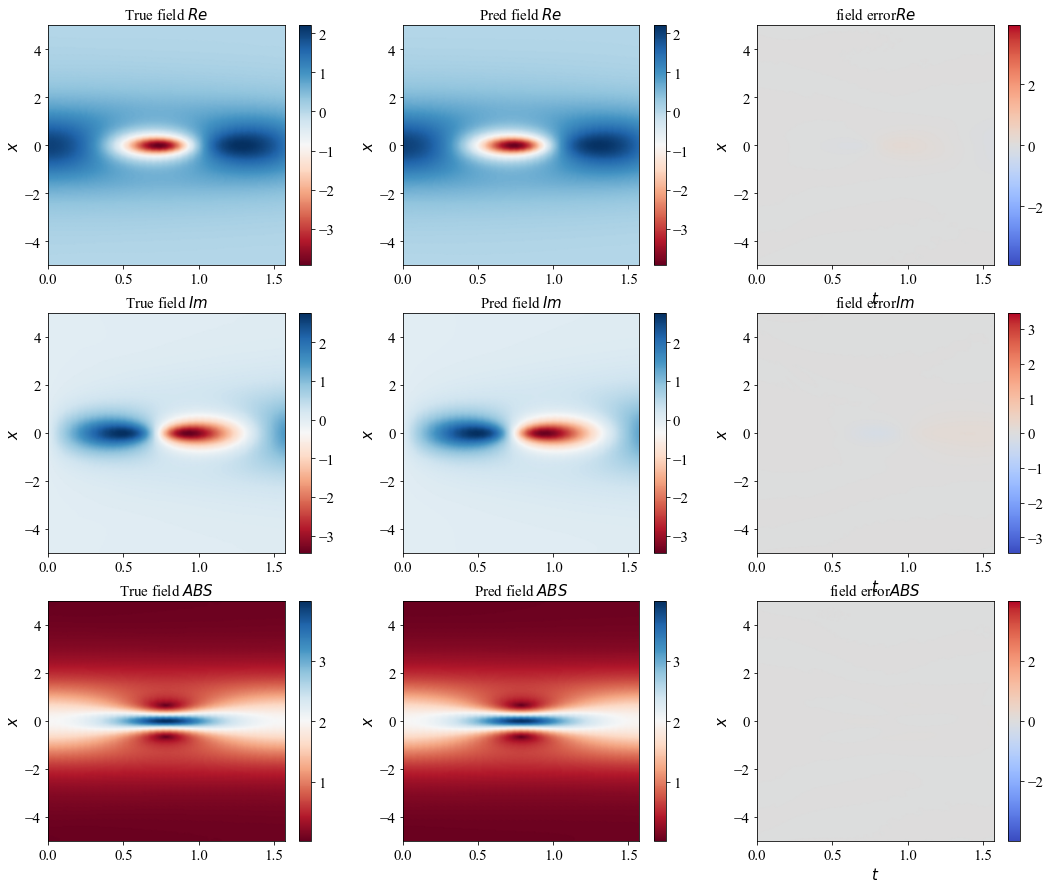

In [17]:
field_pred, equation = inference(inn_var, Net_model)

input_visual = input
field_visual_t = np.concatenate((field, np.sqrt(field[..., (0,)]**2 + field[..., (1,)]**2)), axis=-1)
field_visual_p = field_pred.detach().cpu().numpy()
field_visual_p = np.concatenate((field_visual_p, np.sqrt(field_visual_p[..., (0,)]**2 + field_visual_p[..., (1,)]**2)), axis=-1)

fig = plt.figure(figsize=(18, 15))
Visual.plot_fields_ms(field_visual_t, field_visual_p, input_visual, field_name=('Re', 'Im', 'ABS'))


#### 残差分布

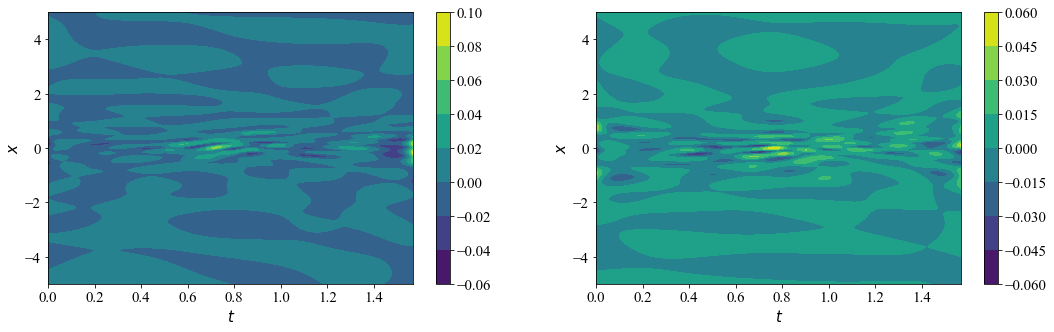

In [18]:
plt.figure(1, figsize=(18, 5))
plt.clf()
plt.subplot(121)
plt.contourf(input_visual[..., 0], input_visual[..., 1], equation[..., 0].detach().cpu().numpy())
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()
plt.subplot(122)
plt.contourf(input_visual[..., 0], input_visual[..., 1], equation[..., 1].detach().cpu().numpy())
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()



#### 细节对比

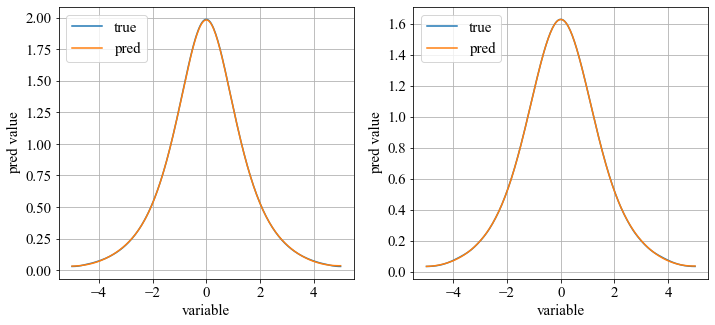

In [19]:
plt.figure(1, figsize=(18, 5))

plt.subplot(131)
Visual.plot_value(input_visual[5, :, 1], field_visual_t[5, :, 0], 'true')
Visual.plot_value(input_visual[5, :, 1], field_visual_p[5, :, 0], 'pred')
plt.subplot(132)
Visual.plot_value(input_visual[100, :, 1], field_visual_t[100, :, 0], 'true')
Visual.plot_value(input_visual[100, :, 1], field_visual_p[100, :, 0], 'pred')
plt.clf()
plt.subplot(132)
Visual.plot_value(input_visual[200, :, 1], field_visual_t[200, :, 0], 'true')
Visual.plot_value(input_visual[200, :, 1], field_visual_p[200, :, 0], 'pred')